In [1]:
import pandas as pd

In [2]:
import sys
sys.path.insert(0, "../")
from dataAnalysis.DataAnalysis import DataAnalysis
import pandas as pd
import torch
 
data = pd.read_csv(r"../sbcdata.csv", header=0)
data_analysis = DataAnalysis(data)

In [3]:
data = pd.concat((data_analysis.get_training_data(), data_analysis.get_testing_data()))
max_Id = data["Id"].unique().max()
gw_data = data_analysis.get_gw_testing_data().copy(deep=True)
gw_data = gw_data.assign(Id=lambda x: x.Id + max_Id)
data = pd.concat((data, gw_data))
data = data.sort_values(["Id", "Time"])
data = data.reset_index(drop=True)
popped_index = data.pop("index")

In [4]:
train = (data["Center"] == "Leipzig") & (data["Set"] == "Training")
test = (data["Center"] == "Leipzig") & (data["Set"] == "Validation")
val = (data["Center"] == "Greifswald") & (data["Set"] == "Validation")

In [5]:
train = torch.from_numpy(train.values)
test = torch.from_numpy(test.values)
val = torch.from_numpy(val.values)

In [6]:
import torch
from dataAnalysis.Constants import SEX_CATEGORY_COLUMN_NAME, SEX_COLUMN_NAME, FEATURES, LABEL_COLUMN_NAME

data[SEX_CATEGORY_COLUMN_NAME] = data.loc[:, SEX_COLUMN_NAME] =="W"

data[SEX_CATEGORY_COLUMN_NAME] = data[SEX_CATEGORY_COLUMN_NAME].astype("int8")
data["Label"] = data["Label"] == "Sepsis"
data["Label"] = data["Label"].astype("int8")

X = data[FEATURES].values
y = data[LABEL_COLUMN_NAME].values

In [7]:
from sklearn.preprocessing import QuantileTransformer

scaler = QuantileTransformer(output_distribution="normal")
scaler.fit(X[train])
X = scaler.transform(X)

In [8]:
X = torch.from_numpy(X)
y = torch.from_numpy(y)

In [9]:
id_grouped_data = data.groupby("Id")

In [10]:
import numpy as np
from tqdm.notebook import tqdm

edge_index_list = []
time_steps = 12

i = 0
for Id, group in tqdm(id_grouped_data):
    indices = group.index
    offset = indices[0]
    num_nodes = len(indices)
    indices = torch.from_numpy(indices.values)

    edge_indices = []
    for i in range(indices.shape[0]):
        sample_indices = indices[:i+1]
        padded_sample_indices = torch.nn.functional.pad(sample_indices, (time_steps - len(sample_indices), 0), mode='constant', value=sample_indices[0])
        edge_indices.append(padded_sample_indices.unsqueeze(0))
    edge_index_list.extend(edge_indices)

  0%|          | 0/866517 [00:00<?, ?it/s]

In [11]:
edge_index = torch.concat(edge_index_list, 0)

In [12]:
new_X_list = []
for i in range(edge_index.shape[0]):
    new_X_list.append(torch.index_select(X, 0, edge_index[i, :]).unsqueeze(0))

In [13]:
X_times = torch.concat(new_X_list, dim = 0)

In [14]:
device = torch.device("cuda:2") if torch.cuda.is_available() else torch.device("cpu")

y = y.to(device)
X_times = X_times.to(device)

In [15]:
X_times = X_times.type(torch.float32)
y = y.type(torch.float32)

In [17]:
train_idc = torch.where(train)[0]
new_train_idc = train_idc[:round(train_idc.shape[0]*.8)]
new_val_idc = train_idc[round(train_idc.shape[0]*.8):]
new_train = torch.zeros_like(train)
new_val = torch.zeros_like(train)
new_train[new_train_idc] = 1
new_val[new_val_idc] = 1
new_train = new_train.type(torch.bool)
new_val = new_val.type(torch.bool)

In [18]:
sets = dict()
sets["train"] = X_times[new_train]
sets["val"] = X_times[new_val]
sets["test"] =  X_times[test]
sets["gw_test"] =  X_times[val]

In [19]:
labels = dict()
labels["train"] = y[new_train]
labels["val"] = y[new_val]
labels["test"] =  y[test]
labels["gw_test"] =  y[val]

In [20]:
losses = dict()
losses["train"] = []
losses["val"] = []
losses["test"] = []
losses["gw_test"] = []

In [21]:
aurocs = dict()
aurocs["train"] = []
aurocs["val"] = []
aurocs["test"] = []
aurocs["gw_test"] = []

In [22]:
counts = torch.unique(y[train], return_counts=True)[-1]
WEIGHT = counts[0] / counts[-1]
WEIGHT

tensor(664.1861, device='cuda:2')

In [41]:
from sklearn.metrics import roc_auc_score

def evaluate(model, batch_loader, set_name):
    global X_times, losses, labels
    with torch.inference_mode():
        model.eval()
        acc_loss = 0
        batch_size = 0
        acc_labels = []
        acc_proba = []
        
        for x,y in batch_loader[set_name]:
            logits = model(x.permute(0, 2, 1))
            last_logits_set = torch.squeeze(logits)
            loss = torch.nn.functional.binary_cross_entropy_with_logits(last_logits_set, y,pos_weight=WEIGHT)
            last_proba_set = torch.sigmoid(last_logits_set)
            acc_labels.extend(y.cpu().tolist())
            acc_proba.extend(last_proba_set.cpu().tolist())
            acc_loss += loss.item()
            batch_size+= x.shape[0]
        losses[set_name].append(acc_loss/batch_size)
        auroc = roc_auc_score(np.array(acc_labels), np.array(acc_proba))
        aurocs[set_name].append(auroc)
        # print(f"{set_name} has AUROC: {auroc}")

In [42]:
def full_batch_epoch(model, batch_loader):
    global X_times, y, sets
    model.train()
    optim.zero_grad()
    acc_loss = 0
    
    for x,y in batch_loader["train"]:
        logits = model(x.permute(0, 2, 1))
        loss = torch.nn.functional.binary_cross_entropy_with_logits(torch.squeeze(logits), y,pos_weight=WEIGHT)
        acc_loss+= loss.item()
        loss.backward()
    for set_name in sets:
        evaluate(model, batch_loader, set_name)
    optim.step()
    return acc_loss

In [40]:
class AttentionLayer(nn.Module):
    def __init__(self, d_model, nhead):
        super(AttentionLayer, self).__init__()
        self.self_attention = nn.MultiheadAttention(d_model, nhead)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, x):
        attn_output, _ = self.self_attention(x, x, x)
        x = x + attn_output
        x = self.layer_norm(x)
        return x

class TransformerModel(nn.Module):
    def __init__(self, input_size, num_classes, d_model=64, nhead=4, num_layers=3):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, d_model)
        self.attention_layers = nn.ModuleList([AttentionLayer(d_model, nhead) for _ in range(num_layers)])
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x.permute(0, 2, 1))  # Adjust input shape for the transformer
        for layer in self.attention_layers:
            x = layer(x)
        x = self.pool(x.transpose(1, 2)).squeeze(-1)
        x = self.fc(x)
        return x

In [100]:
from torch import nn
from torch.autograd import Variable 

class CNNModel(nn.Module):
    def __init__(self, input_size, num_classes, hidden_dim, sequence_length):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=hidden_dim, kernel_size=3, device=device)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.sequence_length = sequence_length
        self.fc = nn.Linear(160, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [101]:
def empty_dict(dictionary):
    for key in dictionary.keys():
        dictionary[key] = []

In [102]:
def transfer_dict(dictionary,device):
    for key in dictionary.keys():
        dictionary[key] = dictionary[key].to(device)

In [103]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

class Data(Dataset):
    # Constructor
    def __init__(self,X, y):
        self.x = X
        self.y = y
        self.len = self.x.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

In [104]:
batch_loader = dict()
batch_loader["train"] = []
batch_loader["val"] = []
batch_loader["test"] = []
batch_loader["gw_test"] = []

In [105]:
def add_loader(set_name):
    global bitch_loader, sets, labels
    dataset = Data(sets[set_name], labels[set_name])
    loader = DataLoader(dataset=dataset, batch_size=50_000) #max is 100_000
    batch_loader[set_name] = loader

In [106]:
for set_name in sets.keys():
    add_loader(set_name)

In [111]:
from tqdm.notebook import tqdm
import time

is_continue = True
if not is_continue:
    model = CNNModel(input_size=X.shape[1], num_classes=1, hidden_dim=32, sequence_length = 12).to(device)
    
    transfer_dict(sets, device)
    transfer_dict(labels, device)
    empty_dict(losses)
    empty_dict(aurocs)
    lr = 0.001
    ## weight decay
    weight_decay = 1e-4
    optim = torch.optim.Adam(params=model.parameters(), lr = lr, weight_decay=weight_decay)

patience = 10
epochs = 30

for epoch in tqdm(range(epochs)):
    print(epoch)
    start = time.time()
    loss = full_batch_epoch(model, batch_loader)
    if len(losses["val"]) > patience and all(list(map(lambda l: l<=losses["val"][-1], losses["val"][-patience-1:]))):
        break
    print(loss)

  0%|          | 0/30 [00:00<?, ?it/s]

0
15.90196293592453
1
15.883257508277893
2
15.865476965904236
3
15.848434329032898
4
15.832108736038208
5
15.816481351852417
6
15.801553189754486
7
15.78711074590683
8
15.773257315158844
9
15.759856879711151
10
15.746768414974213
11
15.733958542346954
12
15.721644043922424
13
15.709723114967346
14
15.698044180870056
15
15.686620652675629
16
15.675375998020172
17
15.664315640926361
18
15.653435945510864
19
15.642675280570984
20
15.632126867771149
21
15.621743023395538
22
15.61155778169632
23
15.601536929607391
24
15.591688811779022
25
15.58204460144043
26
15.57248705625534
27
15.56303185224533
28
15.553717136383057
29
15.544672727584839


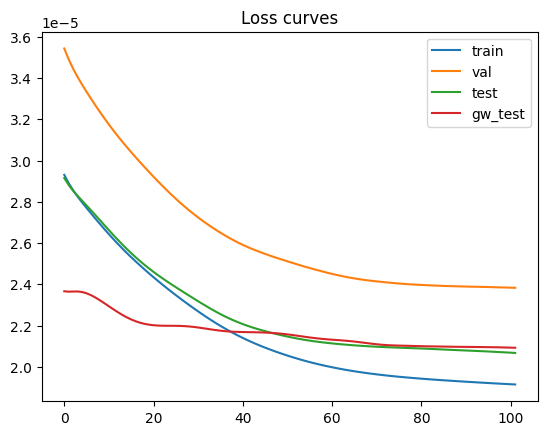

In [114]:
import matplotlib.pyplot as plt

for set_name in losses:
    plt.plot(losses[set_name])
plt.legend(losses.keys())
plt.title("Loss curves")
plt.show()

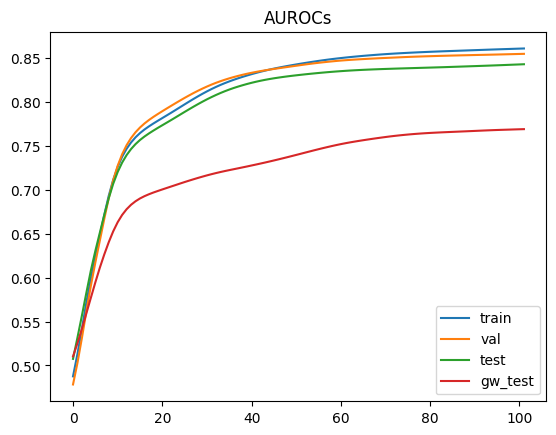

In [115]:
import matplotlib.pyplot as plt

for set_name in aurocs:
    plt.plot(aurocs[set_name])
plt.legend(aurocs.keys())
plt.title("AUROCs")
plt.show()

In [116]:
max(aurocs["test"])

0.8425513501354002

In [117]:
aurocs["test"][-1]

0.8425513501354002

## Evaluate the time series equence lengths

In [307]:
id_grouped_data.size().describe()

count    866517.000000
mean          2.099711
std           3.201005
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         416.000000
dtype: float64

In [312]:
num_sampples_list =  []
for i in range(id_grouped_data.size().max()+1):
    num_samples = (id_grouped_data.size() == i).sum()
    num_sampples_list.append(num_samples)

Text(0.5, 0, 'Length of time series')

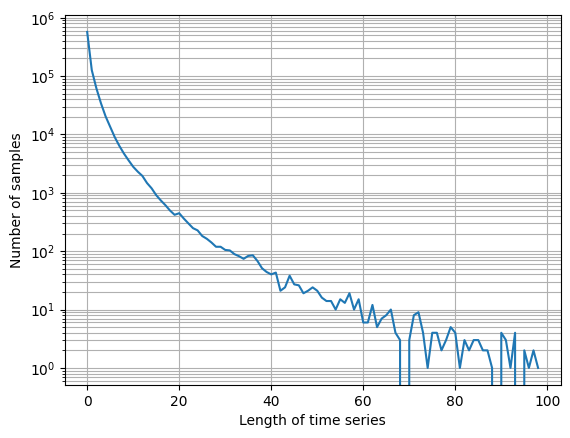

In [322]:
import matplotlib.pyplot as plt
plt.semilogy(num_sampples_list[1:100])
plt.grid(which="both")
plt.ylabel("Number of samples")
plt.xlabel("Length of time series")